# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
# Download and load the CIFAR-10 training dataset
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 29377187.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

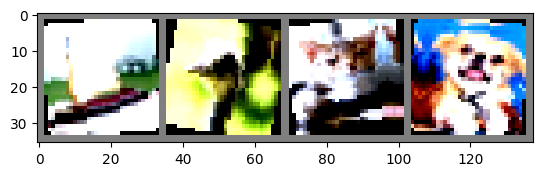

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# The model

In [7]:
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.ReLU(),
            # Define your Group Normalization layers
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 26

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 12

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 12


        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 10

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 8

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(8, 32),
            nn.Dropout(dropout_value)
        )  # output_size = 6



        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )  # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)




    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3,32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

# Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 21
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.6905739307403564 Batch_id=97 Accuracy=27.55: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 1.7021, Accuracy: 3706/10000 (37.06%)

EPOCH: 1


Loss=1.5510135889053345 Batch_id=97 Accuracy=39.26: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]



Test set: Average loss: 1.4827, Accuracy: 4610/10000 (46.10%)

EPOCH: 2


Loss=1.5205405950546265 Batch_id=97 Accuracy=44.21: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 1.4125, Accuracy: 4844/10000 (48.44%)

EPOCH: 3


Loss=1.4255120754241943 Batch_id=97 Accuracy=48.44: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 1.2988, Accuracy: 5269/10000 (52.69%)

EPOCH: 4


Loss=1.454236388206482 Batch_id=97 Accuracy=51.48: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 1.3091, Accuracy: 5247/10000 (52.47%)

EPOCH: 5


Loss=1.2329893112182617 Batch_id=97 Accuracy=53.26: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 1.2133, Accuracy: 5606/10000 (56.06%)

EPOCH: 6


Loss=1.185590147972107 Batch_id=97 Accuracy=55.19: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 1.1656, Accuracy: 5796/10000 (57.96%)

EPOCH: 7


Loss=1.0825368165969849 Batch_id=97 Accuracy=57.25: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 1.1443, Accuracy: 5889/10000 (58.89%)

EPOCH: 8


Loss=1.0117107629776 Batch_id=97 Accuracy=59.15: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 1.0626, Accuracy: 6216/10000 (62.16%)

EPOCH: 9


Loss=1.1785008907318115 Batch_id=97 Accuracy=60.15: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s]



Test set: Average loss: 1.0036, Accuracy: 6377/10000 (63.77%)

EPOCH: 10


Loss=1.051694631576538 Batch_id=97 Accuracy=60.97: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 1.0452, Accuracy: 6333/10000 (63.33%)

EPOCH: 11


Loss=1.1978280544281006 Batch_id=97 Accuracy=62.24: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 1.0468, Accuracy: 6299/10000 (62.99%)

EPOCH: 12


Loss=1.0216946601867676 Batch_id=97 Accuracy=62.80: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.9307, Accuracy: 6700/10000 (67.00%)

EPOCH: 13


Loss=1.113516926765442 Batch_id=97 Accuracy=63.98: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.9290, Accuracy: 6710/10000 (67.10%)

EPOCH: 14


Loss=0.9256383776664734 Batch_id=97 Accuracy=64.78: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.9045, Accuracy: 6827/10000 (68.27%)

EPOCH: 15


Loss=0.9828906059265137 Batch_id=97 Accuracy=65.89: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 0.9073, Accuracy: 6817/10000 (68.17%)

EPOCH: 16


Loss=0.9594274163246155 Batch_id=97 Accuracy=65.94: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]



Test set: Average loss: 0.8580, Accuracy: 6968/10000 (69.68%)

EPOCH: 17


Loss=0.934554398059845 Batch_id=97 Accuracy=66.67: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.8496, Accuracy: 7035/10000 (70.35%)

EPOCH: 18


Loss=0.8697504997253418 Batch_id=97 Accuracy=67.21: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.8778, Accuracy: 6893/10000 (68.93%)

EPOCH: 19


Loss=0.9097899198532104 Batch_id=97 Accuracy=67.59: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.8197, Accuracy: 7100/10000 (71.00%)

EPOCH: 20


Loss=0.9220667481422424 Batch_id=97 Accuracy=68.10: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]



Test set: Average loss: 0.8303, Accuracy: 7104/10000 (71.04%)



Target
  1. Make this network:

      a) C1 C2 c3 P1 C3 C4 C5 c6 P2 C7 C8 C9 GAP C10

      b) Keep the parameter count less than 50000

      c) Try and add one layer to another

      d) Max Epochs is 20

Result
  1. Out Best Training accuracy was 68.10 %
  2. Out Best Testing accuracy was 71.04 %

Analysis
  1. We can still see the underfitting
  2. We have use Group Normalization
  3. After using Group Normalization, we can see that there is drop in both train & test accuracy as compared to Batch Normalization